## Машинное обучение. Работа с данными и построение регрессионных моделей
##### Подготовил Кипренко Евгений
email: zhenyakiprenko@gmail.com

Загружаем наш изначальный (полный) ДатаФрейм, чтобы выделить из него тестовый Датафрейм.<br><br>
**Важно:** в первой части лабораторной работы я использовал тестовый датасет лишь для тестирования написанного кода. Но анализ графиков и выполнение пукнтов первой части ЛР были  сделаны на оригинальном полном датасете.<br><br>
Я решил, что мой тестовый Датафрейм, в контексте данной задачи, будет 5%, что равно 0.05.Аргументирую это тем, что полный датасет в 5000+ данных очень долго будет обрабатываться. А 5%, что равно примерно 250 записям - нет.\
Насколько я понял, в предоставленном датасете первый столбец это просто номера строк. Потому я указал параметр `index_col=0` при считывании csv файла, чтобы номера строк брались из этого первого столбца.

In [1]:
import pandas as pd
import json

df = pd.read_csv('cinema1.csv', index_col=0)


**ЕСЛИ ВЫ ХОТИТЕ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ (УМЕНЬШЕНЫЙ) ДАТАСЕТ, РАСКОММЕНТИРУЙТЕ ЭТИ ДВЕ СЛЕДУЮЩИЕ СТРОКИ**

In [2]:
# test_dataset_size = int(0.05 * len(df))
# df = df.iloc[0:test_dataset_size]

In [3]:
print('Размер обрабатываемого датафрейма:', len(df))

Размер обрабатываемого датафрейма: 5050


Далее, удалим из нашего ДатаФрейма столбцы, которые не заполнены хотя бы на половину данными. Функция `missing_values_table` не моя, спёр её с одной статьи на Хабре, я лишь немножечко подправил её для условий своей задачи. Украл, кажись, [отсюда](https://habr.com/ru/company/nix/blog/425253/).

In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("В датафрейме " + str(df.shape[1]) + " столбцов.\n"    
            "Имеются " + str(mis_val_table_ren_columns.shape[0]) +
              " столбцов, в которых есть отсутствующие значения.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_df = missing_values_table(df);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('Будет удалено %d столбцов.' % len(missing_columns), 'среди которых такие: ', missing_columns)

# Drop the columns
df = df.drop(columns = missing_columns)

В датафрейме 31 столбцов.
Имеются 22 столбцов, в которых есть отсутствующие значения.
Будет удалено 1 столбцов. среди которых такие:  ['Unnamed: 28']


Заменяем NaN на -1.
Выбрал -1 потому, что это частая практика в программировании заменять отсутствие значения таким числом. Плюс, насколько я заметил, в наших данных все числа больше 0, а это значит, что я не внесу своими минус единицами проблем.

In [5]:
df = df.replace("-1", -1)
df = df.fillna(-1)

Сохраним наш тестовый Датафрейм.

In [6]:
df.to_csv(path_or_buf='test_cinema1.csv')

Для удобства, выведу сюда столбцы нашего датафрейма. Заюзаем json чтобы вывести красивенько. Сделаем функцию для красивой печати списков, словарей и т. д.

In [7]:
def prettify(iterable):
    return json.dumps(iterable, indent=4)

In [8]:
print('Наш Датафрейм имеет такие столбцы:\n')
df.info()

Наш Датафрейм имеет такие столбцы:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 0 to 5049
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5050 non-null   object 
 1   director_name              5050 non-null   object 
 2   num_critic_for_reviews     5050 non-null   float64
 3   duration                   5050 non-null   float64
 4   director_facebook_likes    5050 non-null   float64
 5   actor_3_facebook_likes     5050 non-null   float64
 6   actor_2_name               5050 non-null   object 
 7   actor_1_facebook_likes     5050 non-null   float64
 8   gross                      5050 non-null   float64
 9   genres                     5050 non-null   object 
 10  actor_1_name               5050 non-null   object 
 11  movie_title                5050 non-null   object 
 12  num_voted_users            5050 non-null   object 
 13  cast_total_f

**Дадим описательные характеристики наших данных:**<br>
Наши данные это таблица с информацией о фильмах. Каждая строка это один какой-то конкретный, существующий фильм, а столбцы это разные показатели или данные фильма.<br>
У нас 30 столбцов, описывать все нет смысла. Я наведу описание лишь самых важных столбцов.
* director_name - имя режиссёра фильма;
* duration - продолжительность фильма по времени;
* director_facebook_likes - количество лайков режиссёра в соц. сети Facebook;
* actor_1_name - имя первого из трёх главных актёров в фильме;
* actor_2_name - имя второго из трёх главных актёров в фильме;
* actor_3_name - имя третьего из трёх главных актёров в фильме;
* actor_1_facebook_likes - количество лайков в соц. сети Facebook первого из трёх главных актёров в фильме;
* actor_2_facebook_likes - количество лайков в соц. сети Facebook второго из трёх главных актёров в фильме;
* actor_3_facebook_likes - количество лайков в соц. сети Facebook третьего из трёх главных актёров в фильме;
* gross - прибыль фильма в прокате;
* genres - жанры, в которых был снят фильм;
* movie_title - название фильма;
* plot_keywords - ключевые слова из сценария фильма;
* language - язык озвучки фильма;
* country - страна-производитель фильма;
* content_rating - возрастное ограничение фильма;
* budget - бюджет фильма;
* imdb_score - рейтинг фильма на сайте [IMDB](https://www.imdb.com/);
* movie_facebook_likes - количество лайков фильма в соц. сети Facebook.

### Построим распределение жанров по рейтингу, прибыльности, лайкам

Вытащим жанры, лайки, прибыль и рейтинг фильмов, чтобы построить наше распределение.
**Надеюсь я не ошибся и правильно понял, что прибыль это 'gross'.**
В качестве рейтинга используем Рейтинг IMDB

In [9]:
genres_likes_df = df[['genres', 'movie_facebook_likes', 'gross', 'imdb_score']]

Подсчитываем суммарно лайки, прибыль и рейтинг для каждого из жанров. Так как жанров у фильма несколько, то мы разделяем cnhjre c ними, чтобы получить конкретные жанры и считаем для каждого отдельно. Для разделения используем `row['genres'].split('|')`, ведь | это спецсимвол, что разделяет жанры в строке жанров у каждого фильма.
К примеру, если у фильма жанр Fantasy и Adventure, а прибыль 100 000, значит что мы запишем прибиль для Fantasy 100 000 и Adventure 100 000.
Для удобства используем Counter, он нам поможет потом легко отделить лишь самые топовые по показателям жанры.

In [10]:
from collections import Counter

# Добавляет значение в счётчик, если такого ключа там ещё нет.
# Иначе, добавит новое значение к уже имеющемуся
def add_or_sum_to_counter(c: Counter, key: str, value: float):
    if value == -1:
        return
    
    if key in c.keys():
        c[key] += value
    else:
        c[key] = value
    

genres_likes = Counter()
genres_gross = Counter()
genres_score = Counter()
# Считаем сколько фильмов каждого жанра, чтобы потом сделать нормализацию.
genres_films_count = Counter()
for index, row in genres_likes_df.iterrows():
    genres_list = row['genres'].split('|')
    for genre in genres_list:
        add_or_sum_to_counter(genres_likes, genre, float(row['movie_facebook_likes']))
        add_or_sum_to_counter(genres_gross, genre, float(row['gross']))
        add_or_sum_to_counter(genres_score, genre, float(row['imdb_score']))
        add_or_sum_to_counter(genres_films_count, genre, 1)

print('Топ-3 жанра суммарно по лайкам\n', prettify(genres_likes.most_common(3)))
print('Топ-3 жанра суммарно по прибыли\n', prettify(genres_gross.most_common(3)))
print('Топ-3 жанра суммарно по рейтингу\n', prettify(genres_score.most_common(3)))

Топ-3 жанра суммарно по лайкам
 [
    [
        "Drama",
        19963537.0
    ],
    [
        "Adventure",
        12201535.0
    ],
    [
        "Action",
        12021768.0
    ]
]
Топ-3 жанра суммарно по прибыли
 [
    [
        "Adventure",
        79806607293.0
    ],
    [
        "Comedy",
        77439082951.0
    ],
    [
        "Action",
        75145540469.0
    ]
]
Топ-3 жанра суммарно по рейтингу
 [
    [
        "Drama",
        17545.200000000023
    ],
    [
        "Comedy",
        11732.000000000007
    ],
    [
        "Thriller",
        9002.000000000007
    ]
]


##### Делаем нормализацию перед тем как строить распределение по жанрам.
Сначала делим сумму лайков, прибыли и рейтинга для каждого из жанров чтобы найти среднее значение.

In [11]:
def take_avg(c: Counter, key: str, value: float):
    # It's easier to ask for forgiveness than getting permission
    try:
        c[key] = c[key] / value
    except KeyError:
        pass

for genre, films_count in genres_films_count.items():
    take_avg(genres_likes, genre, films_count)
    take_avg(genres_gross, genre, films_count)
    take_avg(genres_score, genre, films_count)
    

print('Топ-3 жанра в среднем по лайкам', genres_likes.most_common(3))
print('Топ-3 жанра в среднем по прибыли',genres_gross.most_common(3))
print('Топ-3 жанра в среднем по рейтингу',genres_score.most_common(3))

Топ-3 жанра в среднем по лайкам [('Sci-Fi', 14889.781199351703), ('Adventure', 13219.431202600217), ('Fantasy', 11238.175122749592)]
Топ-3 жанра в среднем по прибыли [('Animation', 108078638.77366255), ('Adventure', 86464363.26435536), ('Family', 77035505.01465201)]
Топ-3 жанра в среднем по рейтингу [('Film-Noir', 7.633333333333334), ('News', 7.533333333333334), ('Documentary', 7.202459016393445)]


После того, как наши данные были подготовлены, можем рисовать наши графики. Чтобы сделать графики более читаемыми, я решил выводить лишь топ-10. При надобности, вы можете вывести любое число.

**Обратите внимание, что были посчитаны средние значения и проделана нормализация для значений на графиках**

Применим fivethirtyeight, чтобы по красоте всё:)

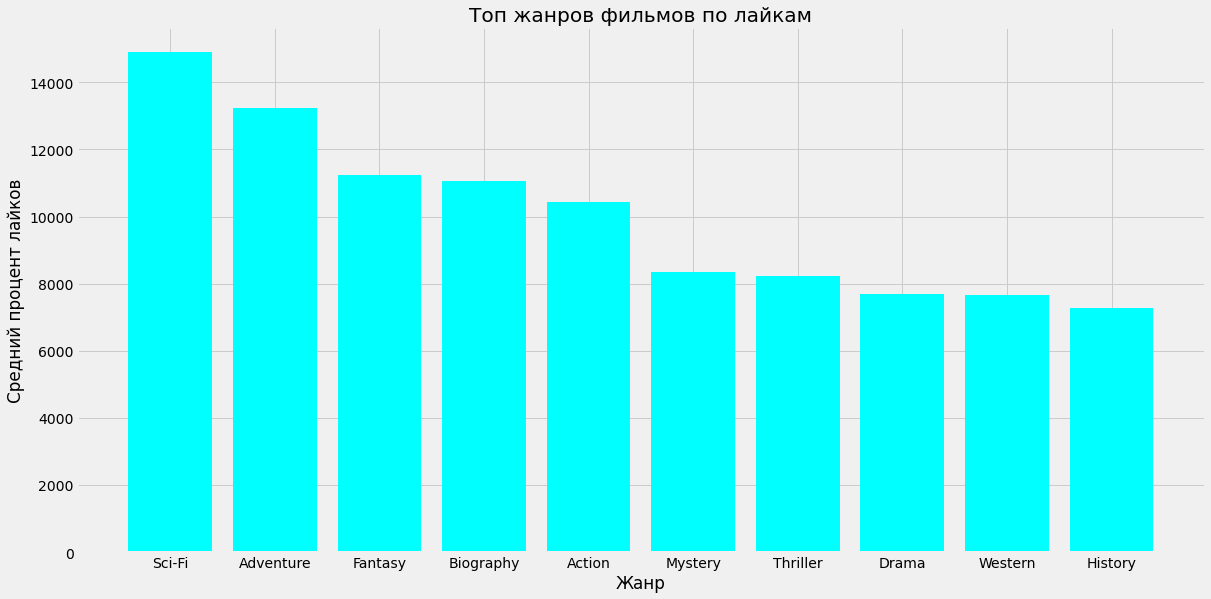

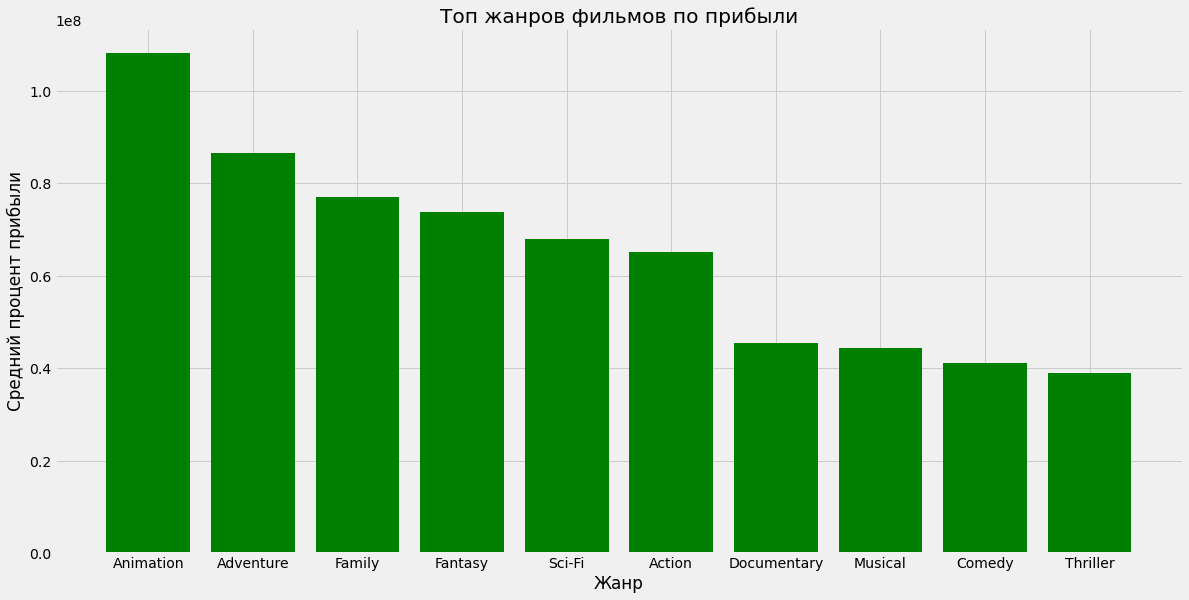

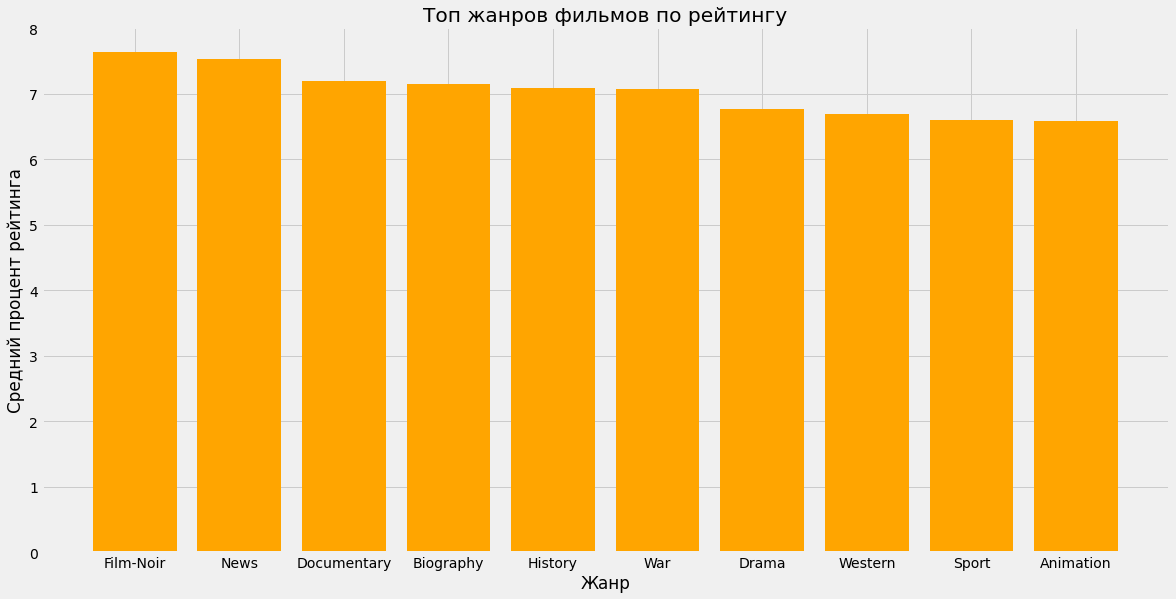

In [12]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

top_genres_by_likes = dict(genres_likes.most_common(10))
plt.figure(figsize=(18, 9))
plt.bar(list(top_genres_by_likes.keys()), list(top_genres_by_likes.values()), color='cyan') 
plt.xlabel('Жанр') 
plt.ylabel('Средний процент лайков') 
plt.title('Топ жанров фильмов по лайкам', color='black')
plt.savefig('Топ жанров фильмов по лайкам.png')
plt.show() 

top_genres_by_gross = dict(genres_gross.most_common(10))
plt.figure(figsize=(18, 9))
plt.bar(list(top_genres_by_gross.keys()), list(top_genres_by_gross.values()), color='green')  
plt.xlabel('Жанр') 
plt.ylabel('Средний процент прибыли') 
plt.title('Топ жанров фильмов по прибыли', color='black')
plt.savefig('Топ жанров фильмов по прибыли.png')
plt.show() 

top_genres_by_score = dict(genres_score.most_common(10))
plt.figure(figsize=(18, 9))
plt.bar(list(top_genres_by_score.keys()), list(top_genres_by_score.values()), color='orange')  
plt.xlabel('Жанр') 
plt.ylabel('Средний процент рейтинга') 
plt.title('Топ жанров фильмов по рейтингу', color='black') 
plt.savefig('Топ жанров фильмов по рейтингу.png')
plt.show() 

**Анализ графиков** в целом, графики довольно обычные. Каких-то особых аномалий я не вижу здесь.

### Найти топ 20 связок (если такие есть) актер-режиссер, которые дают больше денег в прокате

Составим пары режиссёр-актёр, а после будем считать для них статистику.
Используем уже знакомый нам collections.Counter. Не забываем проверочку на -1. 
Если для предыдущих графиков я брал среднее, то в это раз не буду. Дело касается денег и нет смысла брать среднее.

In [13]:
def count_director_actor_gross(c: Counter(), director: str, actor: str, gross: float):
    if director != -1 and actor != -1 and gross != -1:
        director_actor_pair = director.strip() + ' and ' + actor.strip()
        if director_actor_pair in c:
            c[director_actor_pair] += gross
        else:
            c[director_actor_pair] = gross

director_actor_gross = Counter()
for index, row in df[['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'gross']].iterrows():
    director = row['director_name']
    gross = row['gross']
    count_director_actor_gross(director_actor_gross, director, row['actor_1_name'], gross)
    count_director_actor_gross(director_actor_gross, director, row['actor_2_name'], gross)
    count_director_actor_gross(director_actor_gross, director, row['actor_3_name'], gross)

Получили наши данные в формате Режиссёр-Актёр: прибыль, которую они заработали.
Теперь строим наш график и выводим Топ-20 (для чего нам и пригодится Counter).
Подпись Режиссёр-Актёр сделал вертикально, чтобы не сливались надписи.

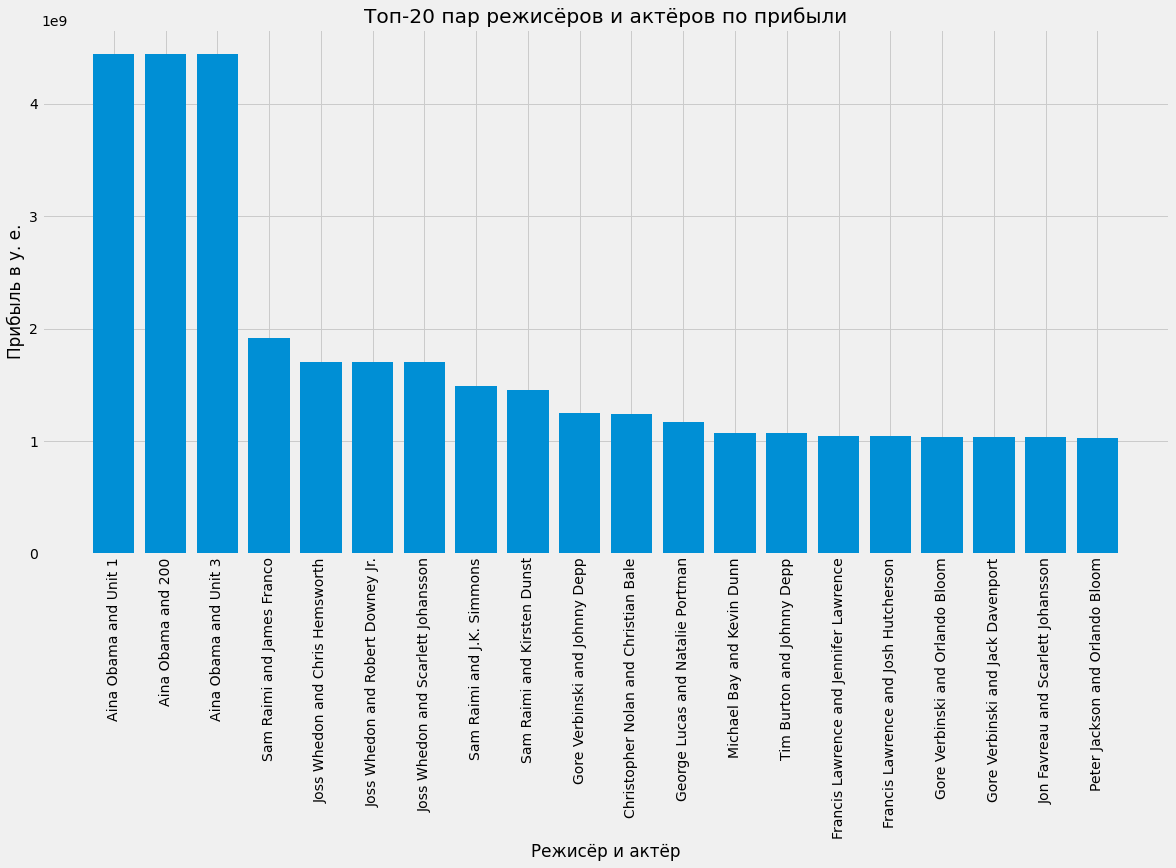

In [14]:
top_dir_act_by_gross = dict(director_actor_gross.most_common(20))
plt.figure(figsize=(18, 9))
heights = [10, 20, 15]
bars = list(top_dir_act_by_gross.keys())
y_pos = range(len(bars))
plt.bar(y_pos, list(top_dir_act_by_gross.values())) 
# Rotation of the bars names
plt.xticks(y_pos, bars, rotation=90, color='black')
plt.xlabel('Режисёр и актёр') 
plt.ylabel('Прибыль в у. е.') 
plt.title('Топ-20 пар режисёров и актёров по прибыли', color='black')
plt.savefig('Топ-20 пар режисёров и актёров по прибыли.png')
plt.show()

**Анализ графика** вот и пасхалочка нашлась. В топе есть три актёра в паре с каким-то неизвестным поиску Google режиссёром. Не уж то пасхалочка. Но об этом потом. Пока что есть другие пункты в лабе :)<br>
По графику сказать больше нечего, выглядит нормальным. Если не рассматривать те странные три пары, которые скорее всего пасхалка, видно, что есть троица из какого-то фильма про Мстителей: режиссёр Джосс Видон, актёры Крис Хэмсворт, Р. Дауни Младший и Скарелт Йохансен. 

### Указать, фильмы из какой страны имеют лучший средний рейтинг. Проанализировать ответ и аргументировать вердикт


In [15]:
country_sum_score = Counter()
counter_film_count = Counter()
for index, row in df[['country', 'imdb_score']].iterrows():
    country = row['country']
    score = row['imdb_score']
    if country == -1 or score == -1:
        continue
    add_or_sum_to_counter(country_sum_score, country, score)
    add_or_sum_to_counter(counter_film_count, country, 1)
print('Количество фильмов по странам \n', prettify(counter_film_count))

Количество фильмов по странам 
 {
    "USA": 3807,
    "UK": 448,
    "New Zealand": 15,
    "Canada": 131,
    "Australia": 55,
    "Belgium": 4,
    "Japan": 23,
    "Germany": 97,
    "China": 30,
    "France": 154,
    "New Line": 1,
    "Mexico": 17,
    "Spain": 33,
    "Hong Kong": 17,
    "Czech Republic": 3,
    "India": 34,
    "Soviet Union": 1,
    "South Korea": 14,
    "Peru": 1,
    "Italy": 23,
    "Russia": 11,
    "Aruba": 1,
    "Denmark": 11,
    "Libya": 1,
    "Ireland": 12,
    "South Africa": 8,
    "Iceland": 3,
    "Switzerland": 3,
    "Romania": 4,
    "West Germany": 3,
    "Chile": 1,
    "Netherlands": 5,
    "Hungary": 2,
    "Panama": 1,
    "Greece": 2,
    "Sweden": 6,
    "Norway": 8,
    "Taiwan": 2,
    "Official site": 1,
    "Cambodia": 1,
    "Thailand": 5,
    "Slovakia": 1,
    "Bulgaria": 1,
    "Iran": 4,
    "Poland": 5,
    "Georgia": 1,
    "Turkey": 1,
    "Nigeria": 1,
    "Brazil": 8,
    "Finland": 1,
    "Bahamas": 1,
    "Argentina"

Видно, что в этом списке не только страны, а и какие-то другие слова. Как например New Line. Запомнили, вернёмся, когда дойдёт очередь до поиска пасхалочек.

Находим среднюю прибыль.

In [16]:
for country, score in country_sum_score.items():
    country_sum_score[country] = score / counter_film_count[country]
print('Средний рейтинг фильмов по странам: \n', prettify(country_sum_score))

Средний рейтинг фильмов по странам: 
 {
    "USA": 6.36782243236144,
    "UK": 6.8183035714285705,
    "New Zealand": 7.279999999999999,
    "Canada": 6.193893129770993,
    "Australia": 6.5145454545454555,
    "Belgium": 5.6,
    "Japan": 6.952173913043477,
    "Germany": 6.340206185567008,
    "China": 6.623333333333332,
    "France": 6.678571428571429,
    "New Line": 4.4,
    "Mexico": 6.776470588235294,
    "Spain": 6.8242424242424224,
    "Hong Kong": 6.741176470588235,
    "Czech Republic": 6.966666666666666,
    "India": 6.532352941176472,
    "Soviet Union": 8.1,
    "South Korea": 6.257142857142858,
    "Peru": 5.4,
    "Italy": 6.873913043478259,
    "Russia": 6.081818181818182,
    "Aruba": 4.8,
    "Denmark": 7.172727272727272,
    "Libya": 8.4,
    "Ireland": 6.783333333333334,
    "South Africa": 6.4375,
    "Iceland": 7.333333333333333,
    "Switzerland": 5.8999999999999995,
    "Romania": 6.6,
    "West Germany": 7.266666666666667,
    "Chile": 6.9,
    "Netherlands": 

И здесь точно так же. Не у всех фильмов в графе страна указана действительно страна. Баг или фича, вот в чём вопрос)

А теперь строим наш график. Вывожу лишь Топ-10 для читаемости. При надобности, можете вывести больше или меньше 

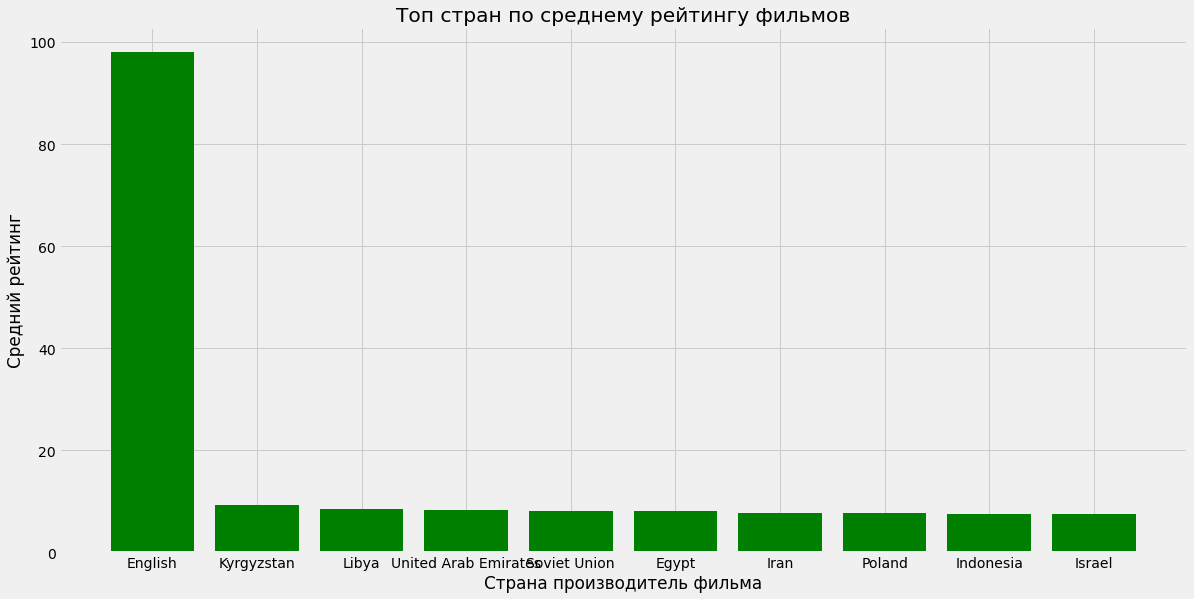

In [17]:
top_film_countries_by_rate = dict(country_sum_score.most_common(10))
plt.figure(figsize=(18, 9))
plt.bar(list(top_film_countries_by_rate.keys()), list(top_film_countries_by_rate.values()), color='green')  
plt.xlabel('Страна производитель фильма') 
plt.ylabel('Средний рейтинг') 
plt.title('Топ стран по среднему рейтингу фильмов', color='black')
plt.savefig('Топ стран по среднему рейтингу фильмов.png')
plt.show() 

**Анализ графика**: мы видим, что в топ вырвались страны, у которых фильмов было меньше.
А это значит, что при подсчёте среднего рейтинга это выбило их в топ.
Ведь если взять США, у которой фильмо много, но они как плохие, так и хорошие, потому средний рейтинг ниже, чем устран, где фильмов мало.
То есть, для более адекватного подсчёта среднего значения, лучше убрать из выборки страны, которые произвели фильмов меньше какого-то определённого значения. Скажем, чтобы фильмов у страны было не менее 10. <br>
**Но самое важное**, что в топе по среднему рейтингу фильмы из страны English. Вроде как страна называется England, а не English. Но что удивительно, средний рейтинг аж 98. А этого быть не может, ведь максимальный средний рейтинг лишь 10. Значит мы видим некорректные данные. Или же пасхалочку.

### Какой сюжет в среднем содержат фильмы жанра драма (plot_keywords). Есть ли у этих фильмов общий сюжетный ход

По условиям задания нам нужны лишь драматические фильмы. Значит вытащим из датафрейма лишь данные о фильмах жанра драма, чтобы упросить компьютеру жизнь при последующих манипуляциях.
так как жанров у фильмов обычно больше чем один, а в нашем датасете жанры записаны в одну строку, применяем contains для поиска вхождения слова _Drama_ в строку жанров каждого из фильмов.

In [18]:
drama_films = df[df['genres'].str.contains('Drama')]

Я решил, что для поиска общего сюжета драматических фильмов, нужно посчитать вхождения слов в plot_keywords, а дальше вывести на график наиболее популярные слова в plot_keywords, а так же самое популярное, что и будет общим сюжетным ходом.
Опять воспользуемся Counter(), очень он удобен для подсчёта всяких таких штук.

In [19]:
drama_films_plot_keywords_list = []
drama_films_count = len(drama_films)
for index, plot_keywords in drama_films['plot_keywords'].iteritems():
    if plot_keywords != -1:
        [drama_films_plot_keywords_list.append(keyword) for keyword in plot_keywords.split('|')]
drama_films_plot_keywords_counter = Counter(drama_films_plot_keywords_list)
print('Всего фильмов в жанре драма: ', drama_films_count)
print('Топ-25 самых используемых слов в сюжете фильмов жанра драма:')
for word in drama_films_plot_keywords_counter.most_common(25):
    print(word[0], " ", word[1])

Всего фильмов в жанре драма:  2594
Топ-25 самых используемых слов в сюжете фильмов жанра драма:
love   143
friend   107
murder   83
death   76
police   70
friendship   56
school   52
new york city   51
high school   46
boy   45
drugs   43
marriage   41
revenge   37
lawyer   35
money   35
female protagonist   34
fbi   33
singer   33
male nudity   32
student   32
hospital   31
sex   31
prison   30
secret   30
texas   30


Любовь, друг, убийство, смерть, полиция. Кто бы сомневался) <br>
Делаем нормализацию перед тем как выводить данные на график.

In [20]:
plot_keywords_count = sum(drama_films_plot_keywords_counter.values())
for word, count in drama_films_plot_keywords_counter.items():
    drama_films_plot_keywords_counter[word] = (count /  plot_keywords_count) * 100

Рисуем наш график, чтобы визуально увидеть, какой общий сюжет преобладает у фильмов в жанре драма.

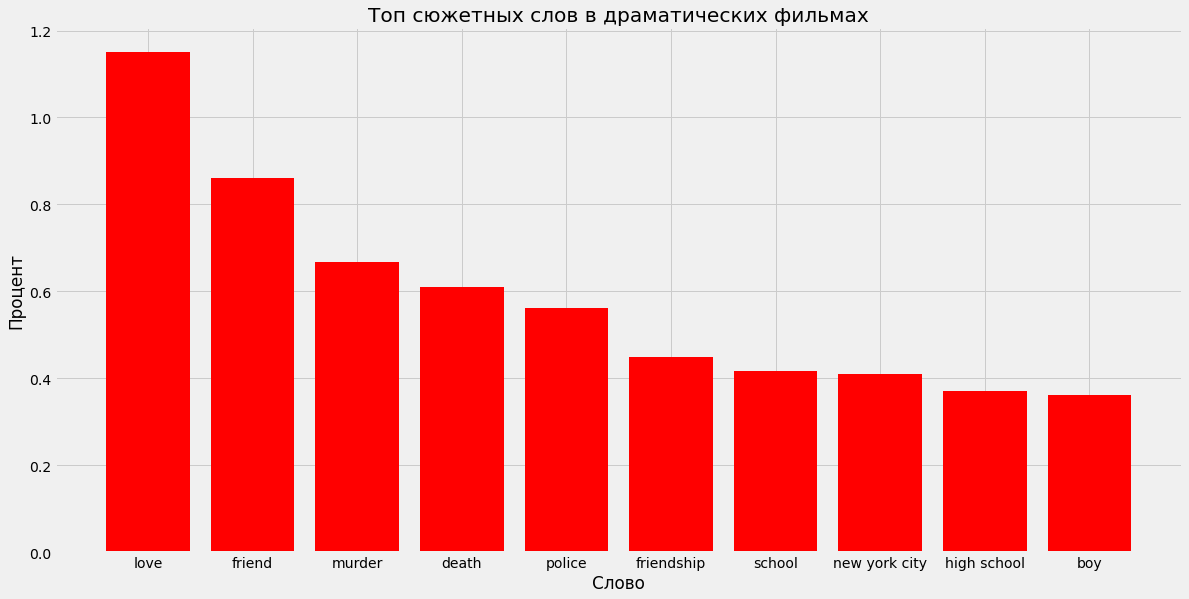

In [21]:
top_films_plot_keywords = dict(drama_films_plot_keywords_counter.most_common(10))
plt.figure(figsize=(18, 9))
plt.bar(list(top_films_plot_keywords.keys()), list(top_films_plot_keywords.values()), color='red')  
plt.xlabel('Слово') 
plt.ylabel('Процент') 
plt.title('Топ сюжетных слов в драматических фильмах', color='black') 
plt.savefig('Топ сюжетных слов в драматических фильмах.png')
plt.show() 

**Анализ графика:** не могу сказать, что есть прямо какой-то общий сюжетный ход среди фильмов в жанре драма, ведь самое популярное слово, любовь, имеет лишь один процент популярности среди сюжетов. Но можно сказать, что сюжеты драматических фильмов довольно часто используют любовь и дружбу, убийства и смерти, полицию и школу. В целом, довольные обычные житейские вещи, кто ожидал здесь увидеть другое. Это же драматические фильмы.

### Влияет ли возрастной рейтинг на бюджет фильма

Я человек простой, чтобы понять, влияет ли возрастной рейтинг на бюджет, сравню средний бюджет фильмов по возрастным рейтингам. А так же найду максимальные бюджеты среди каждого возрастного рейтинга.

In [22]:
content_rating_budget = Counter()
content_rating_films_count = Counter()
for index, row in df[['content_rating', 'budget']].iterrows():
    content_rating = row['content_rating']
    if content_rating != -1: 
        add_or_sum_to_counter(content_rating_budget, content_rating, row['budget'])
        add_or_sum_to_counter(content_rating_films_count, content_rating, 1)
print('Суммарный бюджет фильмов по возрастному ограничению:\n', prettify(content_rating_budget))
print('Количество фильмов по возрастному ограничению:\n', prettify(content_rating_films_count))

Суммарный бюджет фильмов по возрастному ограничению:
 {
    "PG-13": 74983648830.0,
    "PG": 31840328920.0,
    "G": 4814907000.0,
    "R": 65952542481.0,
    "TV-14": 18200000.0,
    "TV-G": 18350000.0,
    "Not Rated": 398649940.0,
    "Unrated": 249555595.0,
    "Approved": 207123765.0,
    "NC-17": 55585000.0,
    "X": 43400000.0,
    "TV-MA": 34000000.0,
    "GP": 22200000.0,
    "Passed": 27282785.0,
    "M": 18800000.0,
    "TV-PG": 9600000.0
}
Количество фильмов по возрастному ограничению:
 {
    "PG-13": 1461,
    "PG": 701,
    "G": 112,
    "R": 2119,
    "TV-14": 30,
    "TV-PG": 13,
    "TV-MA": 20,
    "TV-G": 10,
    "Not Rated": 116,
    "Unrated": 62,
    "Approved": 55,
    "TV-Y": 1,
    "NC-17": 7,
    "X": 13,
    "TV-Y7": 1,
    "GP": 6,
    "Passed": 9,
    "M": 5,
    "USA": 1
}


Получили наши данные: суммарный бюджет фильмов по возрастному ограничению, а так же количество фильмов по возрастному ограничению.<br>
Странно, на последнем месте у нас один фильм из возрастной категории USA. Не уверен, что такая категория существует.
А теперь находим среднее значение бюджета по возрастному ограничению для фильмов.

In [23]:
for content_rating in content_rating_budget.keys():
    take_avg(content_rating_budget, content_rating, content_rating_films_count[content_rating])
print('Средний бюджет фильмов по возрастному рейтингу: \n', prettify(content_rating_budget))

Средний бюджет фильмов по возрастному рейтингу: 
 {
    "PG-13": 51323510.49281314,
    "PG": 45421296.60485022,
    "G": 42990241.071428575,
    "R": 31124371.15667768,
    "TV-14": 606666.6666666666,
    "TV-G": 1835000.0,
    "Not Rated": 3436637.4137931033,
    "Unrated": 4025090.2419354836,
    "Approved": 3765886.6363636362,
    "NC-17": 7940714.285714285,
    "X": 3338461.5384615385,
    "TV-MA": 1700000.0,
    "GP": 3700000.0,
    "Passed": 3031420.5555555555,
    "M": 3760000.0,
    "TV-PG": 738461.5384615385
}


Нашли средние рейтинги бюджетов по возрастным ограничениям. давайте строить наш график.

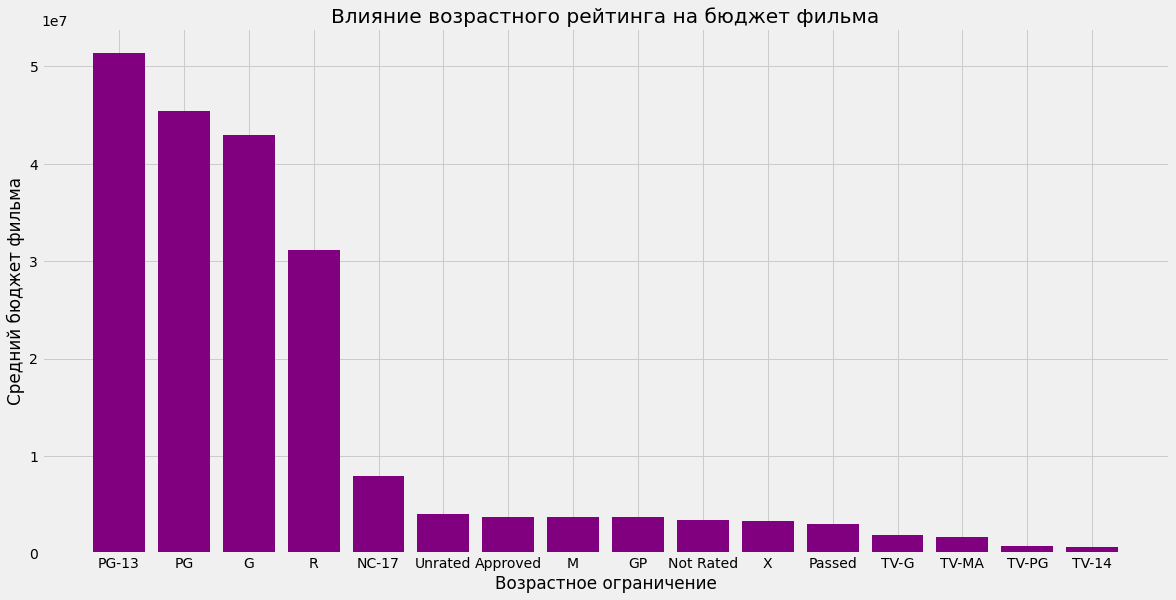

In [24]:
content_rating_budget_dict = dict(content_rating_budget.most_common())
plt.figure(figsize=(18, 9))
plt.bar(list(content_rating_budget_dict.keys()), list(content_rating_budget_dict.values()), color='purple')  
plt.xlabel('Возрастное ограничение') 
plt.ylabel('Средний бюджет фильма') 
plt.title('Влияние возрастного рейтинга на бюджет фильма', color='black') 
plt.savefig('Влияние возрастного рейтинга на бюджет фильма.png')
plt.show() 

**Анализ графика:** мы видим, что первое место по среднему размеру бюджета заняли фильмы PG-13 (Просмотр не желателен детям до 13 лет). В целом, 5 первых мест по среднему бюджету фильма это фильмы, возрастное ограничение которых измеряется по [Системе рейтингов Американской киноассоциации](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D1%80%D0%B5%D0%B9%D1%82%D0%B8%D0%BD%D0%B3%D0%BE%D0%B2_%D0%90%D0%BC%D0%B5%D1%80%D0%B8%D0%BA%D0%B0%D0%BD%D1%81%D0%BA%D0%BE%D0%B9_%D0%BA%D0%B8%D0%BD%D0%BE%D0%B0%D1%81%D1%81%D0%BE%D1%86%D0%B8%D0%B0%D1%86%D0%B8%D0%B8).<br>
Топ-3 по среднему бюджету это фильмы, которые можно смотреть детям до 13 лет (при PG-13 в сопровождении родителей). Основную закономерность я вижу в том, что фильмы, которые рекомендованы людям от 17 лет и выше, имеют значительно меньший бюджет, нежели фильмы, которые можно смотреть до 17 лет. Это можно легко объяснить тем, что чем ниже возрастной порог, тем больше людей посмотрит фильм, плюс, мультики и разные детские фильмы зачастую имеют огромный успех в прокате, потому их бюджет такой раздутый, ведь он окупается.<br>
**Ответ на поставленный вопрос:** да, возрастной рейтинг фильма влияет на его бюджет, чем ниже возрастной рейтинг фильма, тем выше его средний бюджет. PG-13 вышел на первое место потому, что в нашем датасете много мировых хитов, которые, в основном, и сделаны PG-13 рейтингом. Фильмы для 17+ обладают в разы меньшим бюджетом, нежели фильмы разрешённые до 17.

И давайте ещё взглянем на наибольшие бюджеты среди каждой категории.

In [25]:
content_ratings = list(content_rating_budget_dict.keys())
biggest_budgets_by_content_rating = Counter()
for content_rating in content_ratings:
    biggest_budgets_by_content_rating[content_rating] = df[df['content_rating'] == content_rating]['budget'].max()
    
print('Рейтинг максимальных бюджетов фильмов по категориям:\n', prettify(biggest_budgets_by_content_rating.most_common()))

Рейтинг максимальных бюджетов фильмов по категориям:
 [
    [
        "R",
        12215500000.0
    ],
    [
        "PG-13",
        2400000000.0
    ],
    [
        "PG",
        1000000000.0
    ],
    [
        "G",
        200000000.0
    ],
    [
        "Unrated",
        103000000.0
    ],
    [
        "NC-17",
        45000000.0
    ],
    [
        "Not Rated",
        45000000.0
    ],
    [
        "TV-MA",
        34000000.0
    ],
    [
        "Approved",
        31115000.0
    ],
    [
        "GP",
        12000000.0
    ],
    [
        "TV-14",
        12000000.0
    ],
    [
        "X",
        8000000.0
    ],
    [
        "Passed",
        7623000.0
    ],
    [
        "M",
        7000000.0
    ],
    [
        "TV-G",
        7000000.0
    ],
    [
        "TV-PG",
        5000000.0
    ]
]


Если проанализировать, то очень сильно бросается в глаза бюджет 12 215 500 000, надо бы проверить, что там за фильм та такой дорогой. И следующие два за ним тоже что-то сильно много денег имеют в бюджете.<br>
Погуглив, я понял, что в наших данных бюджеты фильмов указаны в разной валюте. Кто-то в долларах, а кто-то в JPY. Значит не пасхалочка.<br>
Получается, если у нас разные валюты указаны, но не указано нигде, какая валюта используется, то все наши графики описывающие деньги являются неточными. Надеюсь, так не было задумано.

### Самое интересное - я целенаправленно внес некоторые некорректные данные (несуществующий фильм или фильмы или фичи) - надо его (их) найти.

Переходим к поиску пасхалок. Напомню списочек странностей, которые я уже замечал, пока делал другие пункты в этой части лабораторной работы:
1. неизвестный Google поиску режиссёр Aina Obama в парах с тремя фейковыми актёрами выбилась в топ по деньгам в прокате;
2. аномальный средний рейтинг в 98 баллов у фильмов из страны English;
3. значения "New Line" и "Official site" в качестве стран у фильмов;
4. фильм, у которого возрастная категория была USA.

Вроде как всё, что я заметил из странного. Приступаем. Начну с простого, глянем, что же это за фильм из страны English с рейтингом в 98 баллов.

In [26]:
print(df[df['country'] == 'English'][['movie_title', 'movie_imdb_link', 'imdb_score']])

     movie_title                                movie_imdb_link  imdb_score
5038   Sanctuary  nudity|party|pirate|swimsuit|three word title        98.0


И мы видим, что тут совсем какая-то беда с данными для этого фильма. Словно кто-то сдвинул их влево или вправо. Потому значения колонок не соответствуют своим колонками. Удалим отсюда этот фильм.

In [27]:
df = df.drop(df[df['country'] == 'English'].index)
print(len(df))

5049


Отлично, переходим к фильму с режиссёром Aina Obama.

In [28]:
print(df[df['director_name'] == 'Aina Obama']
      [['movie_title', 'movie_imdb_link', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']])

     movie_title                                    movie_imdb_link  \
4941  A!O!U!I!E!  http://www.imdb.com/title/tt2403815/?ref_=fn_t...   

     director_name actor_1_name actor_2_name actor_3_name  
4941    Aina Obama       Unit 1          200       Unit 3  


Актёры и имя у фильма странные. Переходим по линке на imdb и видим, что фильм то вовсе и не тот. Режисёр и актёры другие. Имена разве что похожие, из оригинального Aroused  кто-то убрал все согласные и вставил ! вместо них. Фильм то какой подобрали, ставлю лайк, но из наших данных всё таки его уберу.

In [29]:
df = df.drop(df[df['director_name'] == 'Aina Obama'].index)
print(len(df))

5048


Итого мы нашли две из пяти пасхалок. Идём дальше. Посмотрим, что там за "New Line" в качестве страны у фильма.<br>
Я подсмотрел в интернете, есть библиотечка одна, которая страны хранит. Добавлю её, чтобы не набирать руками.<br>
Вам, возможно, она пригодиться для запуска моего ноутбука. Вот так её можно установить `pip install pycountry`.<br>
К сожалению, не все страны учтены в библиотеке, потому добавим руками те, каких не хватает. И не забудем о -1.

In [30]:
import pycountry

countries_names = [country.name for country in list(pycountry.countries)]
countries_names.extend(["USA", "UK", -1, "Czech Republic", "Soviet Union", "South Korea", "Russia", "West Germany", "Taiwan", "Iran"])
print(df[~df['country'].isin(countries_names)][['movie_title', 'movie_imdb_link', 'country']])

          movie_title                                    movie_imdb_link  \
281   Town & Country   http://www.imdb.com/title/tt0141907/?ref_=fn_t...   
2676  Country Strong   http://www.imdb.com/title/tt1555064/?ref_=fn_t...   

            country  
281        New Line  
2676  Official site  


Мы видим, что есть два фильма, у которых некорректная страна указана. Удаляем записи с ними.

In [31]:
df = df.drop(df[~df['country'].isin(countries_names)].index)
print(len(df))

5046


Нашли ещё две испорченных записи с фильмами. Осталась одна.<br>
Посмотрим, что там за фильм был с категорией USA.

In [32]:
print(df[df['content_rating'] == 'USA'][['movie_title', 'movie_imdb_link', 'content_rating']])

Empty DataFrame
Columns: [movie_title, movie_imdb_link, content_rating]
Index: []


Пусто. Мы уже удалили этот фильм.

Если я правильно посчитал, я нашёл 4 испорченных образца. Но всего их пять. После нескольких перепроверок я так и не обнаружил пятый, недостающий. Предполагаю, что им может быть столбец с именем `Unnamed: 28`, который я удалил из датафрейма ещё в начале, так как в нём отсутствовали значения, и даже имя, как мы видим, у столбца отсутствовало.

Сохраним наши очищенные данные в новый файлик.

In [33]:
df.to_csv('filtered_cinema1.csv')

Запустим наш код заново, но уже используя `filtered_cinema1.csv` вместо `cinema1.csv` и увидим, что графики теперь не содержат аномалий. Я не буду дублировать весь выше написанный код. Просто в самом верху страницы подмените имя файла и запустите все ячейки заново.